# Реальная заработная плата в России
Федеральная служба государственной статистики ежемесячно оценивает среднюю реальную заработную плату в России; известны значения с января 1993 по январь 2017 (источник: [http://sophist.hse.ru/exes/tables/WAG_M.htm]. Необходимо построить прогноз на следующие три года.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import pylab
from pmdarima import auto_arima
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing, HoltWintersResults
from dm_test import dm_test
pylab.rcParams['figure.figsize'] = (10, 8)

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
data = pd.read_csv('monthly-wage.csv', sep=';', parse_dates=["Month"], index_col="Month")["Real wage"]

In [56]:
test = data.loc['2014-02':]
data = data.loc[:'2014-01']

<AxesSubplot:xlabel='Month'>

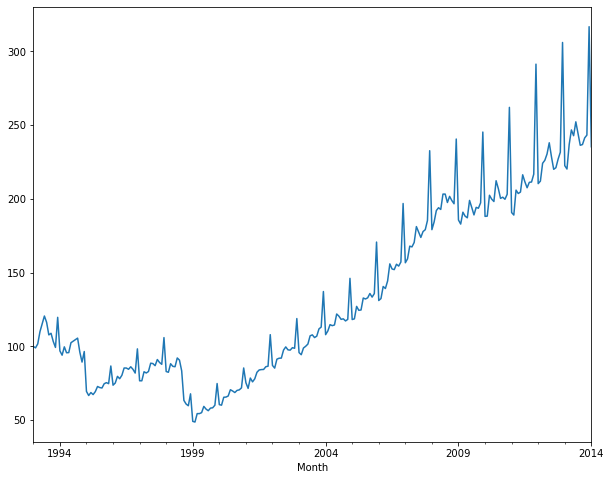

In [57]:
data.plot()

Заметим, что в первые 5 лет признак ведёт себя и меняется не так, как в следующие годы; чтобы модель не перенастраивалась на неактуальные данные, будем рассматривать значения ряда только с января 1999.

In [58]:
data = data.loc['1999-01'::]

<AxesSubplot:xlabel='Month'>

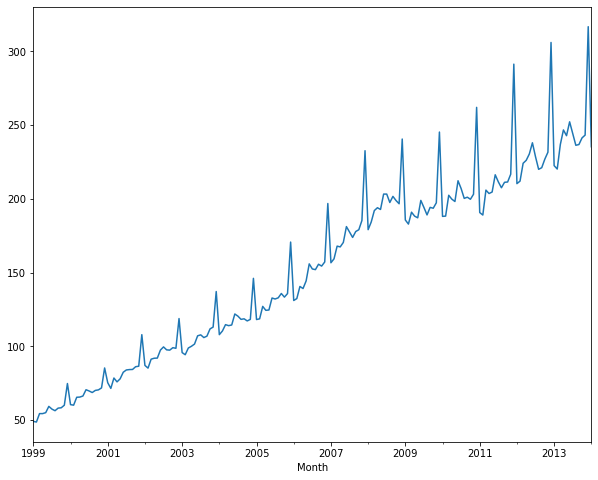

In [59]:
data.plot()

Попробуем поделить на число дней в месяце:

<AxesSubplot:xlabel='Month'>

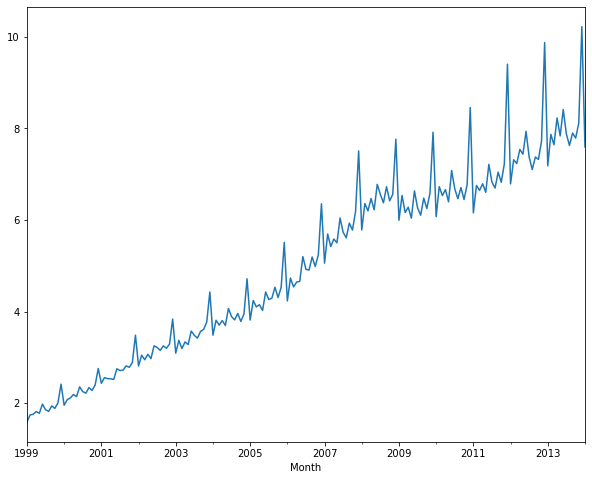

In [60]:
(data/data.index.days_in_month).plot()

Ряд не стал более регулярным, так что вернёмся к исходным данным.

STL-декомпозиция ряда:

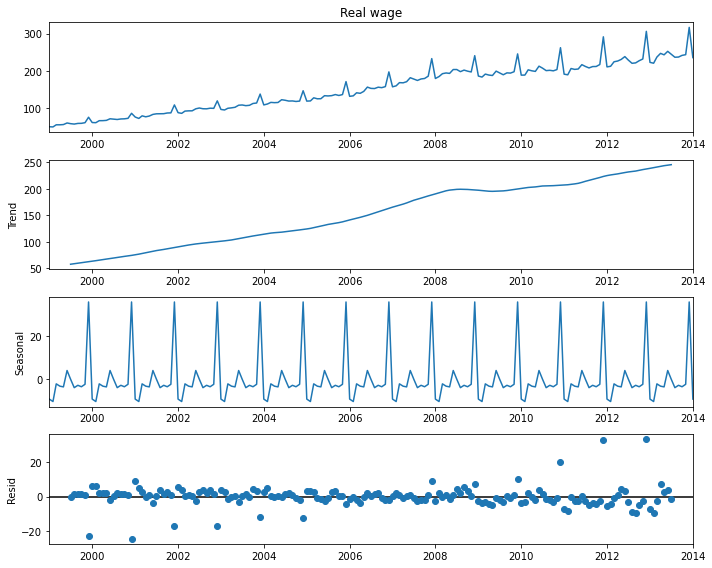

In [61]:
res = sm.tsa.seasonal_decompose(data)
res.plot();

Оптимальное преобразование Бокса-Кокса и результат его применения:

In [62]:
print ('Box-Cox transformation: lambda=%f' %stats.boxcox(data)[1])

Box-Cox transformation: lambda=0.627097


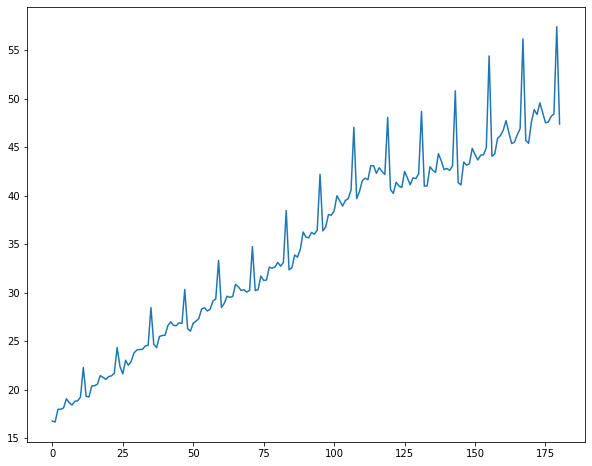

In [63]:
plt.plot(stats.boxcox(data)[0])

В данном случае преобразование имеет смысл использовать, так как оно хорошо стабилизирует дисперсию. Попробуем округлить параметр и взять $\lambda=0$:

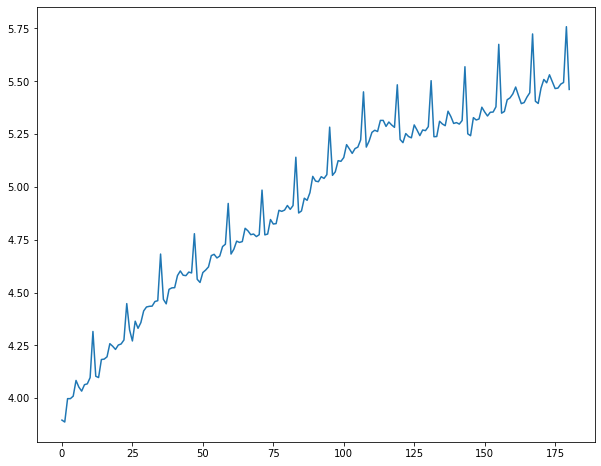

In [64]:
data_bc = stats.boxcox(data, lmbda = 0)
plt.plot(data_bc)

Результат лучше. Далее будем использовать $\lambda=0$.

## Прогноз ARIMA

In [65]:
stepwise_model = auto_arima(data_bc,start_p=0, start_q=0,m=12,seasonal=True,
                            trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-826.937, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-805.015, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-836.306, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-839.504, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-814.679, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-837.753, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-837.696, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-835.381, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-835.505, Time=0.61 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-828.688, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-838.465, Time=0.44 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-838.367, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-840.465, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-816.736, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1

In [66]:
auto_arima_params = stepwise_model.get_params()
print('Proposed ARIMA', auto_arima_params['order'], 
      auto_arima_params['seasonal_order'],
        ' AIC:', stepwise_model.aic(),
        ', BIC:',stepwise_model.bic())

Proposed ARIMA (1, 1, 0) (0, 1, 1, 12)  AIC: -840.4652859955686 , BIC: -831.0933940573589


Посмотрим на остатки модели:

In [67]:
fit_auto_arima = stepwise_model.fit(data_bc)
res_auto_arima = fit_auto_arima.resid()

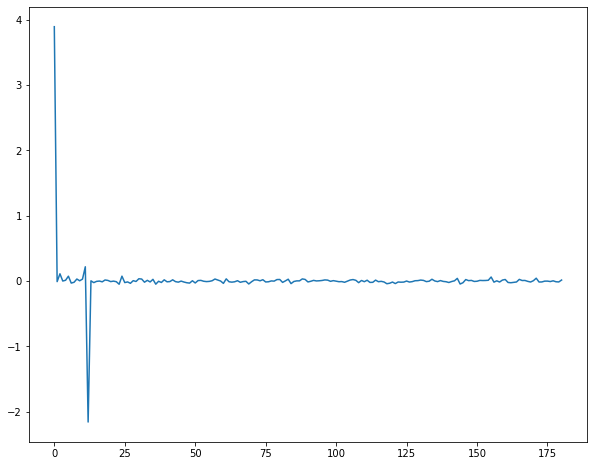

In [68]:
plt.plot(res_auto_arima);

Отрежем первые 13 отсчётов и продолжим анализ:

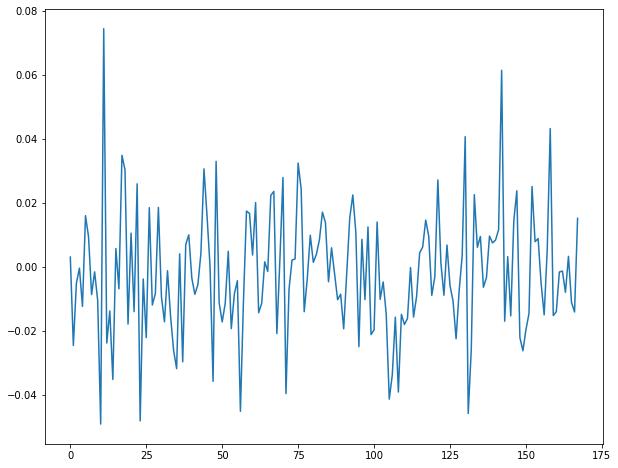

In [69]:
plt.plot(res_auto_arima[13:]);

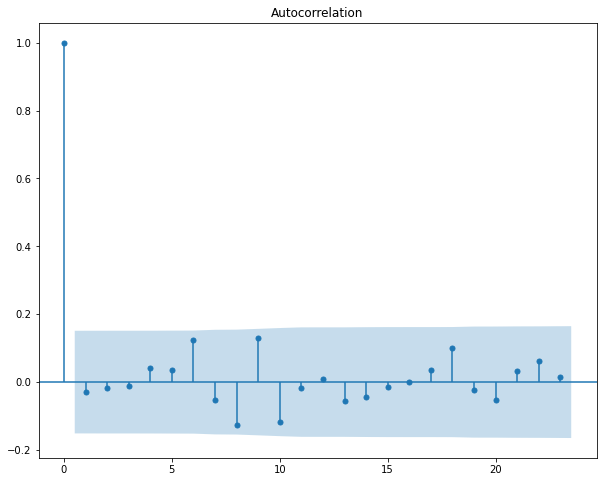

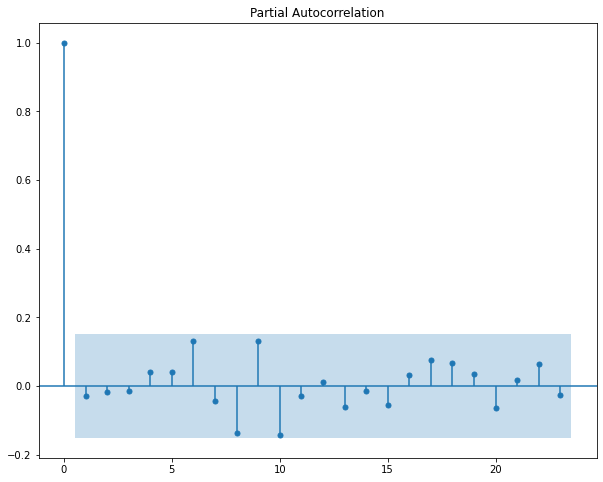

In [70]:
sm.graphics.tsa.plot_acf(res_auto_arima[13:]);
sm.graphics.tsa.plot_pacf(res_auto_arima[13:]);

In [71]:
lb_pvalue = sm.stats.acorr_ljungbox(res_auto_arima[13:], lags=12*3, boxpierce=True, return_df = True)['lb_pvalue']

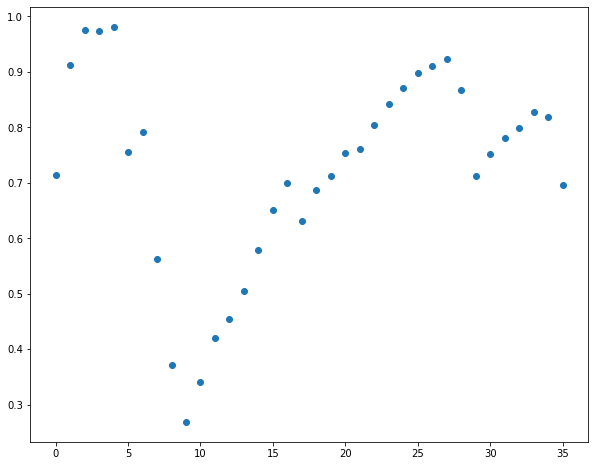

In [72]:
plt.scatter(range(len(lb_pvalue)), lb_pvalue)
plt.show()

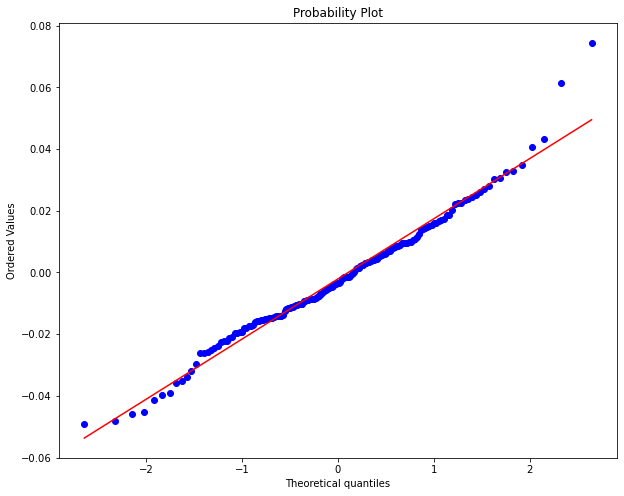

In [73]:
stats.probplot(res_auto_arima[13:], dist="norm", plot=pylab);

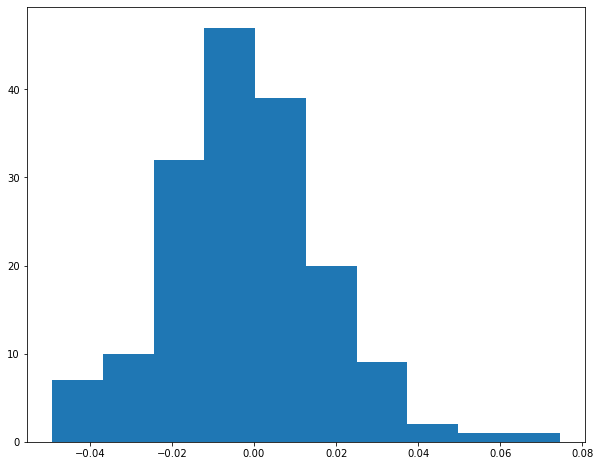

In [74]:
plt.hist(res_auto_arima[13:]);

In [75]:
table_hypothesis = pd.DataFrame([['Нормальность', 'Шапиро-Уилка', 'отвергается', stats.shapiro(res_auto_arima[13:])[1]],
                     ['Несмещённость', 'Уилкоксона', 'не отвергается', stats.wilcoxon(res_auto_arima[13:])[1]],
                     ['Стационарность', 'KPSS', 'не отвергается', sm.tsa.stattools.kpss(res_auto_arima[13:])[1]]])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 
                                           'Достигаемый уровень значимости']
table_hypothesis

,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,отвергается,0.019069
1,Несмещённость,Уилкоксона,не отвергается,0.077412
2,Стационарность,KPSS,не отвергается,0.100000


## Ручной подбор модели

In [76]:
sm.tsa.stattools.kpss(data_bc)[1]

0.01

In [77]:
def difference(dataset, interval=1):
    return dataset[interval:] - dataset[:-interval]

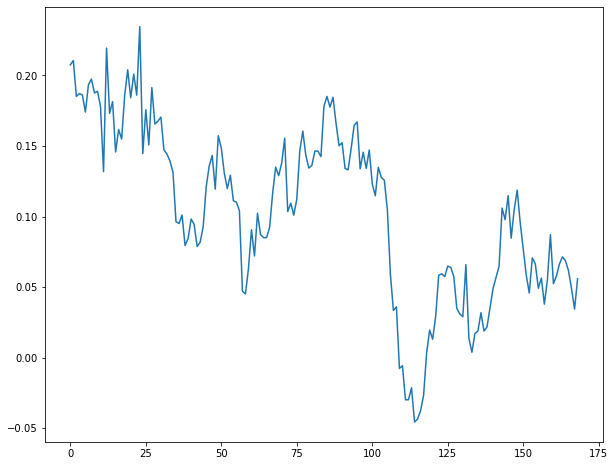

In [78]:
diff_data = difference(data_bc, 12)
plt.plot(diff_data);

In [79]:
sm.tsa.stattools.kpss(diff_data)[1]

0.01

Ряд всё ещё нестационарен (p<0.01, критерий KPSS). Проведём ещё одно дифференцирование:

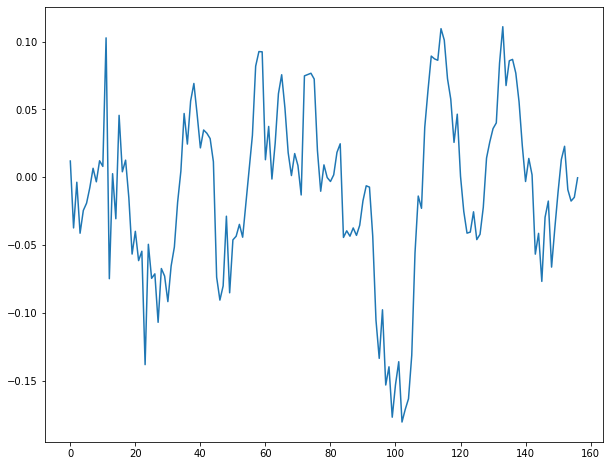

In [80]:
diff2_data = difference(diff_data, 12)
plt.plot(diff2_data);

In [81]:
sm.tsa.stattools.kpss(diff2_data)[1]

0.1

Для полученного ряда гипотеза стационарности не отвергается (p>0.1)

Посмотрим на ACF и PACF полученного продифференцированного ряда:

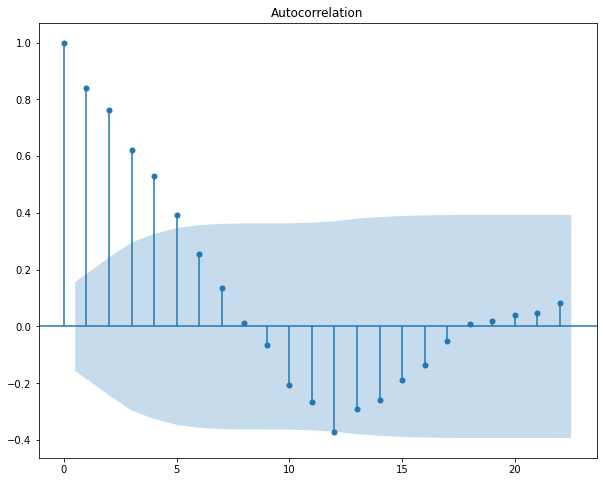

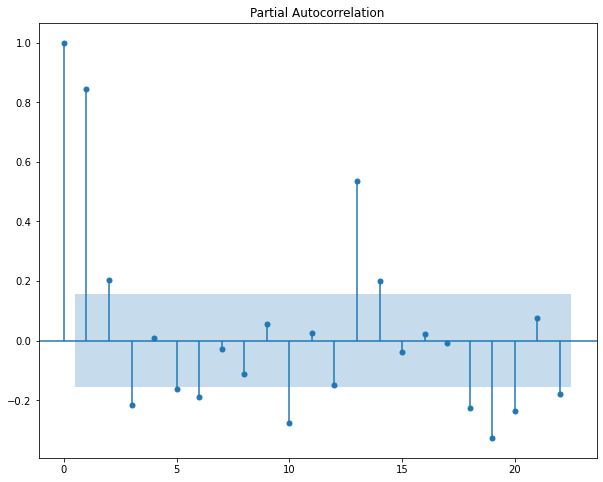

In [82]:
diff2_data = pd.DataFrame(diff2_data)
sm.graphics.tsa.plot_acf(diff2_data);
sm.graphics.tsa.plot_pacf(diff2_data);

На ACF значимы лаги 1, 2, 3, 4, 5, более того график выглядит как синусоида, на PACF — 1, 2, 3, 5, 6, 10, 13, 14, 18, 19, 20, 22. Поищем с помощью auto.arima оптимальную модель полным перебором (stepwise=FALSE) с ограничениями d=2, D=0, max.p=6, max.q=0, max.P=3, max.Q=1, max.order=6:

In [83]:
model_arima = auto_arima(data_bc, start_p=1, start_q=0,
                    max_p=6, max_q=0, max_P=3, max_Q=1, m=12, max_order=6,
                    seasonal=True,
                    d=2, D=0, trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=False)

 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-115.551, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-275.624, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-671.807, Time=0.21 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=-676.571, Time=0.48 sec
 ARIMA(0,2,0)(3,0,0)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,2,0)(3,0,1)[12]             : AIC=-675.479, Time=1.25 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-192.503, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-358.409, Time=0.07 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-763.525, Time=0.24 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-757.274, Time=0.56 sec
 ARIMA(1,2,0)(3,0,0)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,2,0)(3,0,1)[12] 

In [84]:
model_arima_params = model_arima.get_params()
print('Proposed ARIMA', model_arima_params['order'], 
      model_arima_params['seasonal_order'],
        ' AIC:', model_arima.aic(),
        ', BIC:',model_arima.bic())

Proposed ARIMA (4, 2, 0) (1, 0, 1, 12)  AIC: -811.9795733599672 , BIC: -789.6678727190819


In [85]:
model_arima_fit = model_arima.fit(data_bc)

Посмотрим на остатки модели:

In [86]:
res_arima = model_arima_fit.resid()

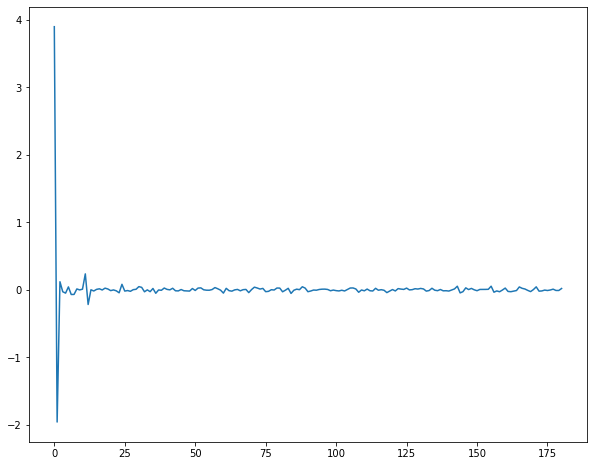

In [87]:
plt.plot(res_arima);

Отрежем первые 13 отсчётов и продолжим анализ:

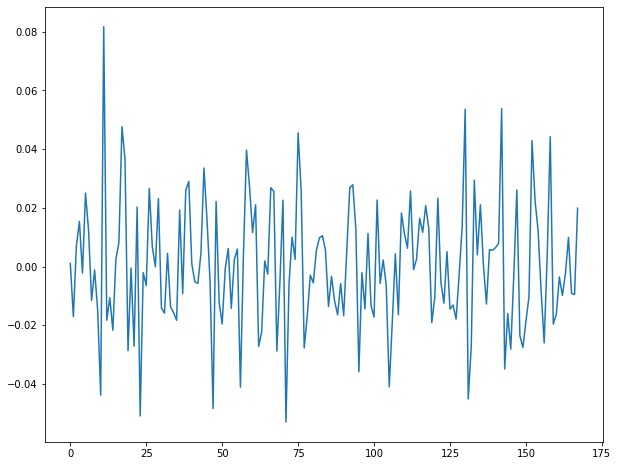

In [88]:
plt.plot(res_arima[13:]);

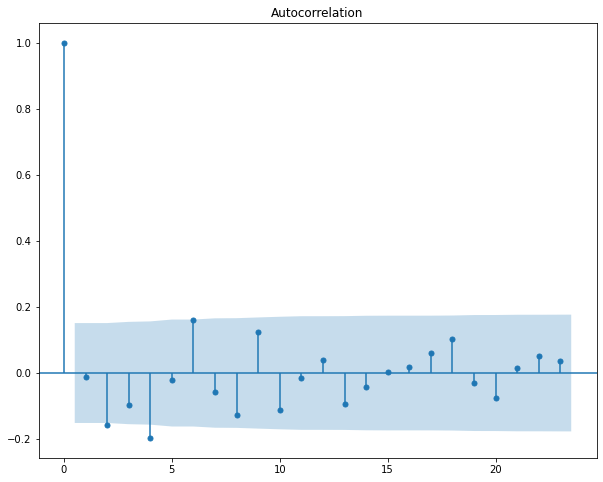

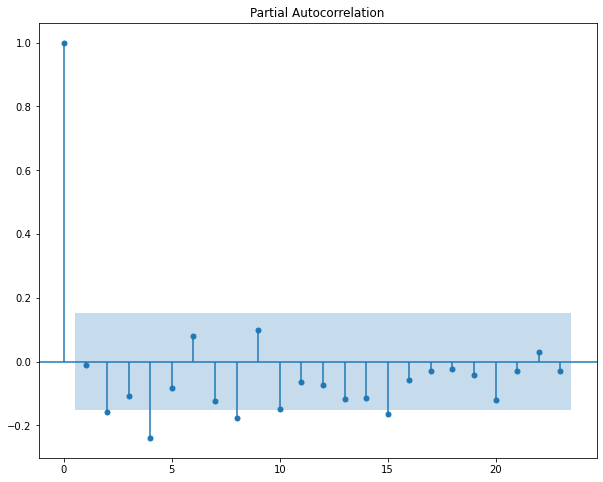

In [89]:
sm.graphics.tsa.plot_acf(res_arima[13:]);
sm.graphics.tsa.plot_pacf(res_arima[13:]);

In [90]:
lb_pvalue = sm.stats.acorr_ljungbox(res_arima[13:], lags=12*3, boxpierce=True, return_df = True)['lb_pvalue']

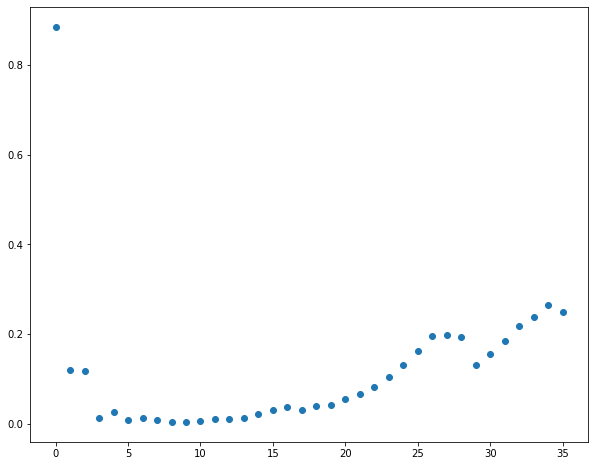

In [91]:
plt.scatter(range(len(lb_pvalue)), lb_pvalue)
plt.show()

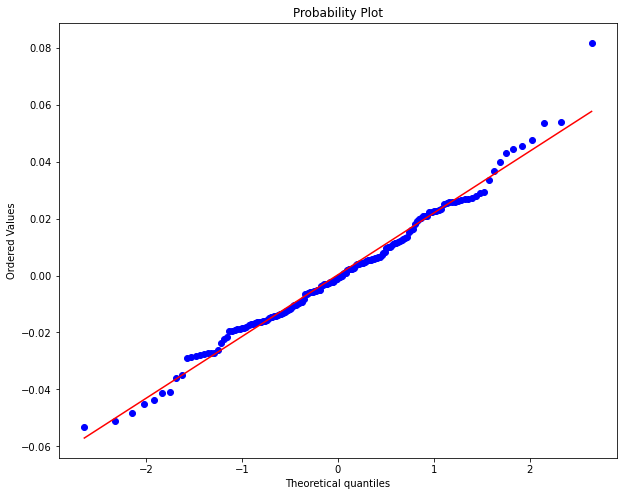

In [92]:
stats.probplot(res_arima[13:], dist="norm", plot=pylab);

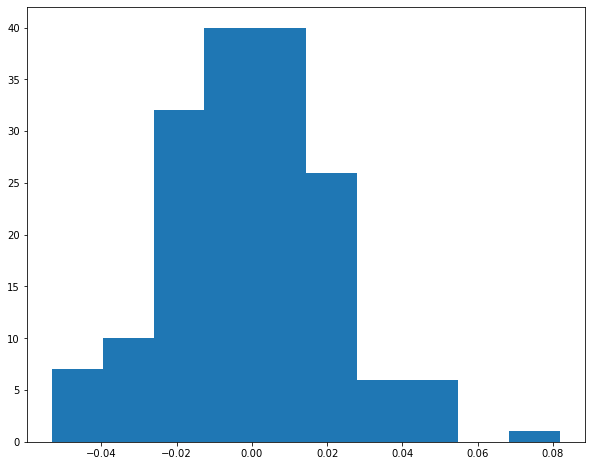

In [93]:
plt.hist(res_arima[13:]);

In [94]:
table_hypothesis = pd.DataFrame([['Нормальность', 'Шапиро-Уилка', 'не отвергается', stats.shapiro(res_arima[13:])[1]],
                     ['Несмещённость', 'Уилкоксона', 'не отвергается', stats.wilcoxon(res_arima[13:])[1]],
                     ['Стационарность', 'KPSS', 'не отвергается', sm.tsa.stattools.kpss(res_arima[13:])[1]]])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 
                                           'Достигаемый уровень значимости']
table_hypothesis

,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,не отвергается,0.095889
1,Несмещённость,Уилкоксона,не отвергается,0.876656
2,Стационарность,KPSS,не отвергается,0.100000


In [95]:
model_arima_pred = inv_boxcox(model_arima_fit.predict(n_periods= len(test)), 0)
auto_arima_pred = inv_boxcox(fit_auto_arima.predict(n_periods= len(test)), 0)

In [96]:
model_arima_pred, arima_conf_int = model_arima_fit.predict(n_periods= len(test), 
                                                           return_conf_int=True,
                                                           alpha=0.01)
auto_arima_pred, auto_arima_conf_int = fit_auto_arima.predict(n_periods= len(test), 
                                                              return_conf_int=True,
                                                              alpha=0.01)

In [97]:
model_arima_pred = inv_boxcox( model_arima_pred, 0)
auto_arima_pred = inv_boxcox(auto_arima_pred, 0)
arima_conf_int = inv_boxcox(arima_conf_int, 0)
auto_arima_conf_int = inv_boxcox(auto_arima_conf_int, 0)

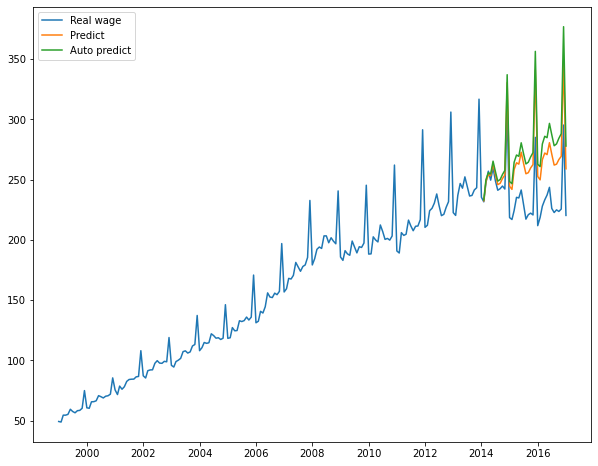

In [98]:
plt.plot(data.append(test), label = 'Real wage')
plt.plot(test.index, model_arima_pred, label = 'Predict')
plt.plot(test.index, auto_arima_pred, label = 'Auto predict')
plt.legend()
plt.show()

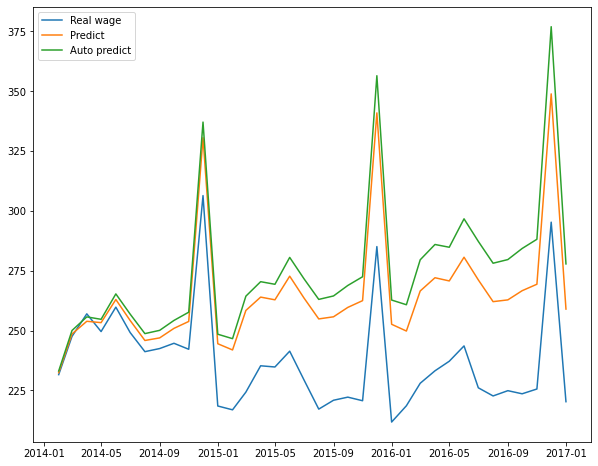

In [99]:
plt.plot(test, label = 'Real wage')
plt.plot(test.index, model_arima_pred, label = 'Predict')
plt.plot(test.index, auto_arima_pred, label = 'Auto predict')
plt.legend()
plt.show()

# Прогноз ETS

Для примера рассмотрим настройку метода ExponentialSmoothing на основе критерия AIC.
https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/   
При сравнении различных методов экспоненциального сглаживания можно использовать следующую методику:
https://www.researchgate.net/publication/222552350_A_State_Space_Framework_for_Automatic_Forecasting_Using_Exponential_Smoothing_Methods

In [89]:
from itertools import product

def exp_smoothing_configs():
    models = []
    t_params = ['add', 'mul']
    d_params = [True, False]
    s_params = ['add', 'mul']
    p = [12]
    b = ['log']
    r_params = [True, False]
    sl_params = np.arange(0,1,0.2)
    ssl_params = np.arange(0,1,0.2)
    sse_params = np.arange(0,1,0.2)
    ds_params = np.arange(0,1,0.2)
    
    models = list(product(t_params, d_params, s_params, p, b,
                 r_params, sl_params, ssl_params, sse_params, ds_params))
    
    return models

In [90]:
def exp_smoothing_forecast(history, len_test, config):
    t,d,s,p,b,r,sl,ssl,sse,ds = config
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model_fit = model.fit(use_boxcox=b, 
                          remove_bias=r, 
                          smoothing_level=sl,                 
                          smoothing_slope = ssl,                  
                          smoothing_seasonal = sse,
                          damping_slope = ds)
    pred = model_fit.forecast(len_test)
    res = model_fit.resid
    aic = model_fit.aic
    return pred,res,aic

In [91]:
cfg_list = exp_smoothing_configs()

In [92]:
predict_ets = []
aic_max = 10000
for cfg in cfg_list:
    predict,res,aic = exp_smoothing_forecast(data, len(test), cfg)
    if (aic < aic_max):
        aic_max = aic
        predict_ets = predict
        res_ets = res

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

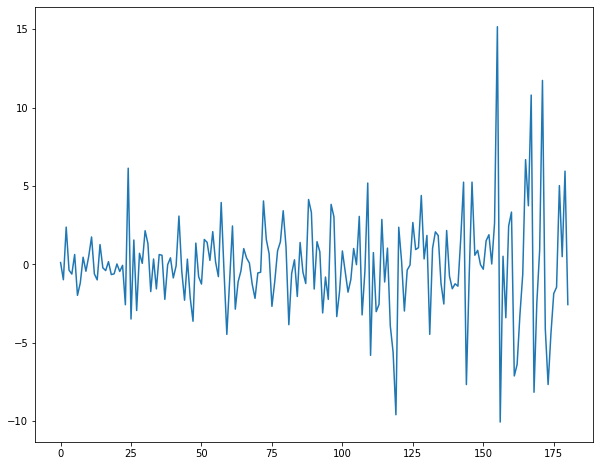

In [93]:
plt.plot(res_ets);

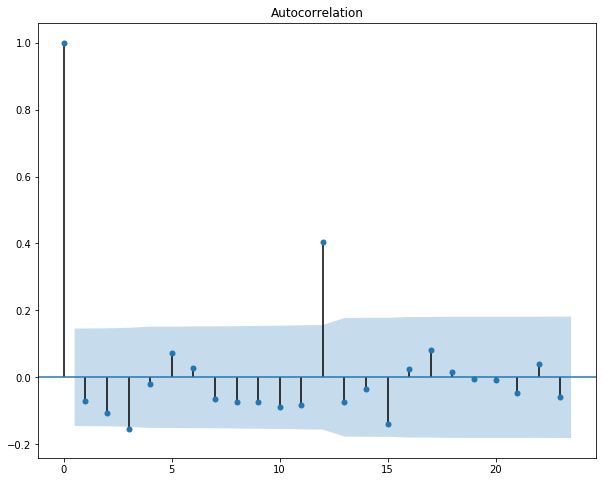

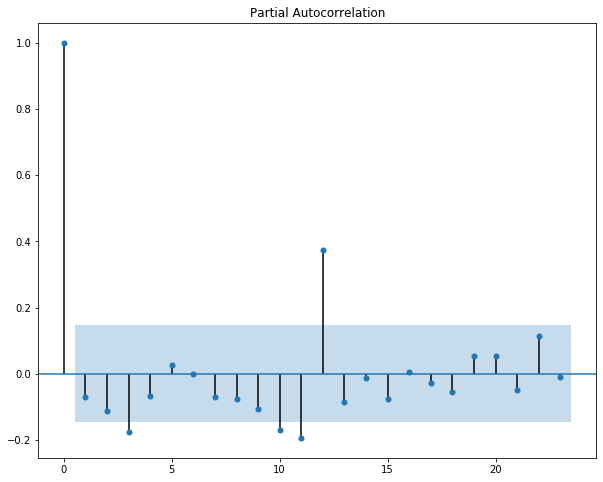

In [94]:
sm.graphics.tsa.plot_acf(res_ets);
sm.graphics.tsa.plot_pacf(res_ets);

In [95]:
lb_pvalue = sm.stats.acorr_ljungbox(res_ets, lags=12*3, boxpierce=True, return_df = True)['lb_pvalue']

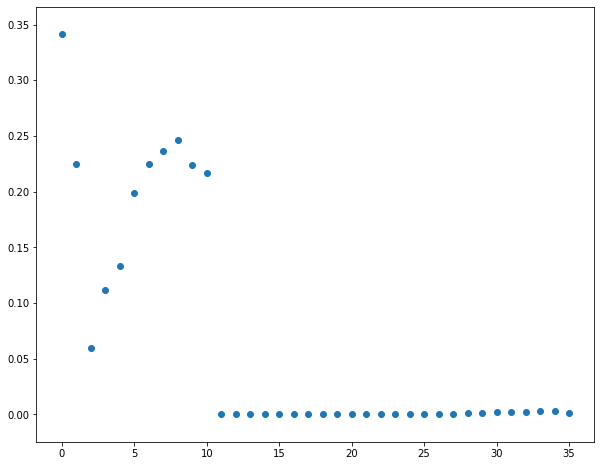

In [96]:
plt.scatter(range(len(lb_pvalue)), lb_pvalue)
plt.show()

Остатки коррелированы, по всей видимости, модель недостаточно хороша.

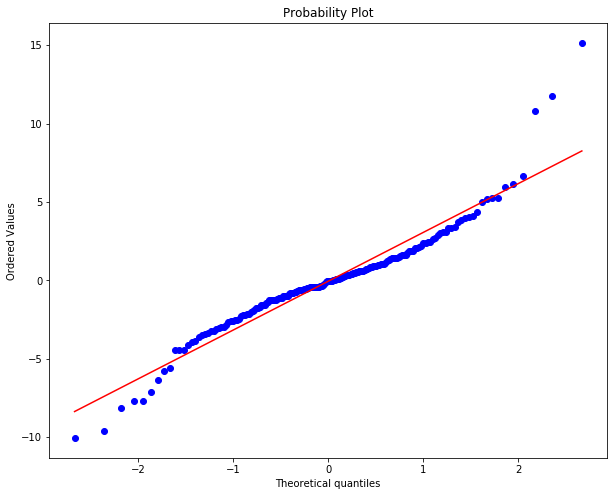

In [97]:
stats.probplot(res_ets, dist="norm", plot=pylab);

Распределение имеет длинные хвосты и выбросы справа.

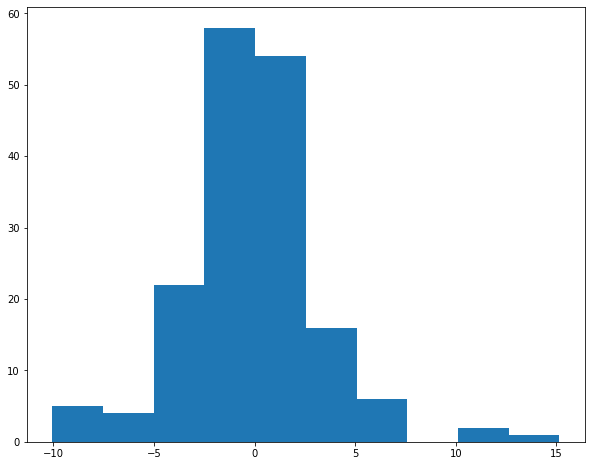

In [98]:
plt.hist(res_ets[13:]);

In [99]:
table_hypothesis = pd.DataFrame([['Нормальность', 'Шапиро-Уилка', 'отвергается', stats.shapiro(res_ets)[1]],
                     ['Несмещённость', 'Уилкоксона', 'отвергается', stats.wilcoxon(res_ets)[1]],
                     ['Стационарность', 'KPSS', 'отвергается', sm.tsa.stattools.kpss(res_ets)[1]]])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 
                                           'Достигаемый уровень значимости']
table_hypothesis

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,отвергается,1.034664e-07
1,Несмещённость,Уилкоксона,отвергается,6.095474e-01
2,Стационарность,KPSS,отвергается,1.000000e-01


## Сравнение моделей

In [ ]:
dm_test(test,auto_arima_pred, model_arima_pred)

In [210]:
dm_test(test,predict_ets, model_arima_pred)

dm_return(DM=6.436373259324607, p_value=2.064121175859463e-07)

Критерий Диболда-Мариано не обнаруживает значимого различия между качеством прогнозов.

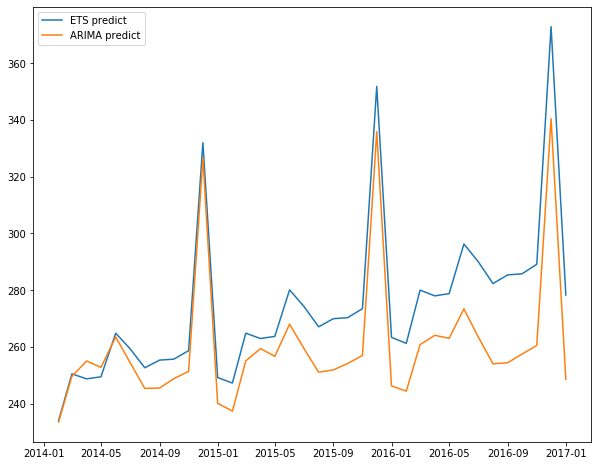

In [211]:

plt.plot(test.index, predict_ets, label = 'ETS predict')
plt.plot(test.index, model_arima_pred, label = 'ARIMA predict')
plt.legend()
plt.show()

Остановимся на модели ARIMA, так как её остатки выглядят лучше. Воспользуемся тем, что остатки ARIMA нормальны на 1% уровне значимости, поэтому возьмем теоретические, а не бутстреп-предсказательные интервалы.

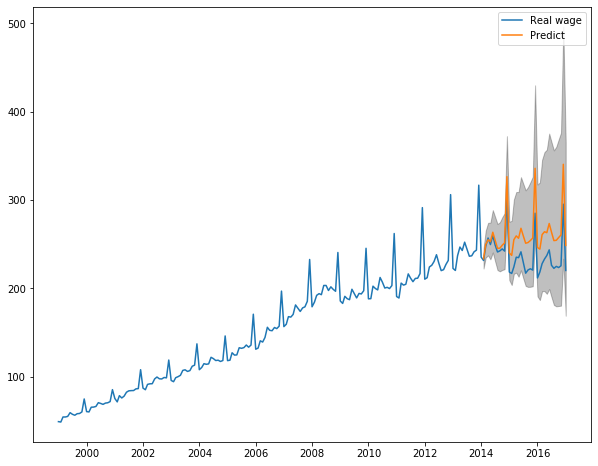

In [212]:
plt.plot(data.append(test), label = 'Real wage')
plt.plot(test.index, model_arima_pred, label = 'Predict')
plt.fill_between(test.index, arima_conf_int[:, 0], arima_conf_int[:, 1], color='k', alpha=.25)
plt.legend()
plt.show()